# convnet 最終出力アニメ画像の作成

複数の入力画像から VGG16 の最後の層の出力画像を作成し全てをアニメーション GIF 化して保存する。特徴量の可視化が目的。

In [7]:
input_files = ["lionfish1.jpg", "lionfish2.jpg", "lionfish3.jpg", "lionfish4.jpg", "lionfish5.jpg"]
output_file = "lionfish.gif"
#input_files = ["kawasemi.jpg", "kawasemi2.jpg", "kawasemi3.jpg", "kawasemi4.jpg", "kawasemi5.jpg"]
#output_file = "kawasemi.gif"

IMAGE: lionfish1.jpg -> (224, 224, 3)
IMAGE: lionfish2.jpg -> (224, 224, 3)
IMAGE: lionfish3.jpg -> (224, 224, 3)
IMAGE: lionfish4.jpg -> (224, 224, 3)
IMAGE: lionfish5.jpg -> (224, 224, 3)
SOURCE: (5, 224, 224, 3)
ACTIVATION: (5, 7, 7, 512)


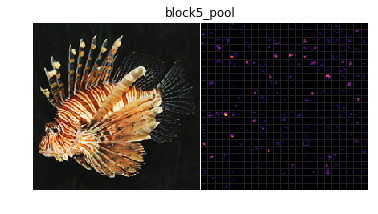

In [8]:
import os, math, cv2
from PIL import Image
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
%matplotlib inline

cm = get_cmap("inferno")

def concat_images(images, spacing=1, space_color=0):
  n_images = len(images)
  rows = math.ceil(math.sqrt(n_images))
  cols = math.ceil(n_images / rows)
  vstack = []
  for y in range(cols):
    size = min(rows, n_images - y * cols)
    hstack = []
    for x in range(rows):
      if x is not 0:
        hstack.append(np.full((images[x-1].shape[0], spacing, 3), space_color, dtype=np.uint8))
      i = y * cols + x
      if i < len(images):
        hstack.append(images[i].astype(np.uint8))
      else:
        hstack.append(np.zeros(images[0].shape, dtype=np.uint8))
    row = cv2.hconcat(hstack)
    vstack.append(row)
    if y + 1 < cols:
      vstack.append(np.full((spacing, row.shape[1], 3), space_color, dtype=np.uint8))
  array = cv2.vconcat(vstack)
  return Image.fromarray(array, "RGB")

src = []
for input_file in input_files:
  img = image.load_img(input_file, target_size=(224, 224))
  img = image.img_to_array(img)
  img = preprocess_input(img)
  print("IMAGE: %s -> %s" % (input_file, str(img.shape)))
  src.append(img)
src = np.stack(src)
print("SOURCE: %s" % str(src.shape))

model = VGG16(weights="imagenet")
layer = model.layers[18]
layer_output = layer.output
activation_model = models.Model(inputs=model.input, outputs=[layer_output])

activations = activation_model.predict(src)
print("ACTIVATION: %s" % str(activations.shape))

activations = (cm(activations / np.max(activations)) * 255).astype(np.int8).transpose((0, 3, 1, 2, 4))[:, :, :, :, :3]
images = []
for i in range(activations.shape[0]):
  heatmap = image.img_to_array(concat_images(activations[i], space_color=0x20)) 
  size = len(heatmap)
  img = image.img_to_array(image.load_img(input_files[i], target_size=(size, size)))
  images.append(concat_images([img, heatmap], space_color=0xFF))
#images = [concat_images(activations[i]) for i in range(activations.shape[0])]

images[0].save(output_file, save_all=True, append_images=images[1:], optimize=False, duration=600, loop=0)
plt.title("%s" % layer.name)
plt.imshow(images[0])
plt.axis("off")
plt.show()
